In [2]:
import numpy as np
import os
from PIL import Image, ImageDraw
import struct
import scipy
import scipy.misc
import scipy.cluster
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline


In [36]:
# %load hcluster.py
from numpy import *

"""
Code for hierarchical clustering, modified from 
Programming Collective Intelligence by Toby Segaran 
(O'Reilly Media 2007, page 33). 
"""

class cluster_node:
    def __init__(self,vec,left=None,right=None,distance=0.0,id=None,count=1):
        self.left=left
        self.right=right
        self.vec=vec
        self.id=id
        self.distance=distance
        self.count=count #only used for weighted average 

def L2dist(v1,v2):
    return sqrt(sum((v1-v2)**2))
    
def L1dist(v1,v2):
    return sum(abs(v1-v2))

# def Chi2dist(v1,v2):
#     return sqrt(sum((v1-v2)**2))

def hcluster(features,distance=L2dist):
    #cluster the rows of the "features" matrix
    distances={}
    currentclustid=-1

    # clusters are initially just the individual rows
    clust=[cluster_node(array(features[i]),id=i) for i in range(len(features))]

    while len(clust)>1:
        lowestpair=(0,1)
        closest=distance(clust[0].vec,clust[1].vec)
    
        # loop through every pair looking for the smallest distance
        for i in range(len(clust)):
            for j in range(i+1,len(clust)):
                # distances is the cache of distance calculations
                if (clust[i].id,clust[j].id) not in distances: 
                    distances[(clust[i].id,clust[j].id)]=distance(clust[i].vec,clust[j].vec)
        
                d=distances[(clust[i].id,clust[j].id)]
        
                if d<closest:
                    closest=d
                    lowestpair=(i,j)
        
        # calculate the average of the two clusters
        mergevec=[(clust[lowestpair[0]].vec[i]+clust[lowestpair[1]].vec[i])/2.0 \
            for i in range(len(clust[0].vec))]
        
        # create the new cluster
        newcluster=cluster_node(array(mergevec),left=clust[lowestpair[0]],
                             right=clust[lowestpair[1]],
                             distance=closest,id=currentclustid)
        
        # cluster ids that weren't in the original set are negative
        currentclustid-=1
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)

    return clust[0]


def extract_clusters(clust,dist):
    # extract list of sub-tree clusters from hcluster tree with distance<dist
    clusters = {}
    if clust.distance<dist:
        # we have found a cluster subtree
        return [clust] 
    else:
        # check the right and left branches
        cl = []
        cr = []
        if clust.left!=None: 
            cl = extract_clusters(clust.left,dist=dist)
        if clust.right!=None: 
            cr = extract_clusters(clust.right,dist=dist)
        return cl+cr 
        
def get_cluster_elements(clust):
    # return ids for elements in a cluster sub-tree
    if clust.id>0:
        # positive id means that this is a leaf
        return [clust.id]
    else:
        # check the right and left branches
        cl = []
        cr = []
        if clust.left!=None: 
            cl = get_cluster_elements(clust.left)
        if clust.right!=None: 
            cr = get_cluster_elements(clust.right)
        return cl+cr


def printclust(clust,labels=None,n=0):
    # indent to make a hierarchy layout
    for i in range(n): print ' ',
    if clust.id<0:
        # negative id means that this is branch
        print '-'
    else:
        # positive id means that this is an endpoint
        if labels==None: print clust.id
        else: print labels[clust.id]
    
    # now print the right and left branches
    if clust.left!=None: printclust(clust.left,labels=labels,n=n+1)
    if clust.right!=None: printclust(clust.right,labels=labels,n=n+1)



def getheight(clust):
    # Is this an endpoint? Then the height is just 1
    if clust.left==None and clust.right==None: return 1
    
    # Otherwise the height is the same of the heights of
    # each branch
    return getheight(clust.left)+getheight(clust.right)

def getdepth(clust):
    # The distance of an endpoint is 0.0
    if clust.left==None and clust.right==None: return 0
    
    # The distance of a branch is the greater of its two sides
    # plus its own distance
    return max(getdepth(clust.left),getdepth(clust.right))+clust.distance
      
      
from PIL import Image,ImageDraw
 
def drawdendrogram(clust,imlist,jpeg='clusters.png', thumbsize=100, fillc=(60,60,60)):
    # height and width
    h=getheight(clust)*thumbsize
    w=2400
    depth=getdepth(clust)
    
    # width is fixed, so scale distances accordingly
    scaling=float(w-150)/depth
    
    # Create a new image with a white background
    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)
    
    draw.line((0,h/2,10,h/2),fill=fillc)    
    
    # Draw the first node
    drawnode(draw,clust,10,(h/2),scaling,imlist,img, thumbsize,fillc)
    img.save(jpeg, quality=100)

def drawnode(draw,clust,x,y,scaling,imlist,img, thumbsize, fillc):
    if clust.id<0:
        h1=getheight(clust.left)*thumbsize
        h2=getheight(clust.right)*thumbsize
        top=y-(h1+h2)/2
        bottom=y+(h1+h2)/2
        # Line length
        ll=clust.distance*scaling
        # Vertical line from this cluster to children    
        draw.line((x,top+h1/2,x,bottom-h2/2),fill=fillc)    
        
        # Horizontal line to left item
        draw.line((x,top+h1/2,x+ll,top+h1/2),fill=fillc)    
        
        # Horizontal line to right item
        draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=fillc)        
        
        # Call the function to draw the left and right nodes    
        drawnode(draw,clust.left,x+ll,top+h1/2,scaling,imlist,img,thumbsize,fillc)
        drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,imlist,img,thumbsize,fillc)
    else:   
        # If this is an endpoint, draw a thumbnail image
        nodeim = Image.open(imlist[clust.id])
        nodeim.thumbnail((thumbsize,thumbsize))
        ns = nodeim.size
        img.paste(nodeim,(int(x),int(y-ns[1]//2),int(x+ns[0]),int(y+ns[1]-ns[1]//2)))


In [4]:
#Absolute folder of images
im_dir = '/Users/noon/Pictures/Pictures by me/'
os.chdir(im_dir)

In [15]:
# Access all PNG files in directory
allfiles=os.listdir(im_dir)
imlist=[filename for filename in allfiles if  filename[-4:] in [".png",".PNG"]]

In [73]:
allfiles=os.listdir(im_dir)
imlist = []
for filename in allfiles:
    if filename[-4:] in [".png",".PNG"] or filename[-4:] in [".jpg",".JPG"] or filename[-5:] in [".jpeg",".JPEG"]:
        imlist.append(filename)

# Assuming all images are the same size, get dimensions of first image
max_w = max(Image.open(im).size[0] for im in imlist)
max_h = max(Image.open(im).size[1] for im in imlist)
print max_w, max_h
N=len(imlist)

# Create a numpy array of floats to store the average (assume RGB images)
arr=np.zeros((max_h,max_w,3),np.float)

# Build up average pixel intensities, casting each image as an array of floats
for im in imlist:
    print 'working on ' + im
    old_im = Image.open(im)
    old_size = old_im.size
    new_size = (max_w, max_h)
    
    new_im = Image.new("RGB", new_size) 
    new_im.paste(old_im, ((new_size[0]-old_size[0])/2,
                          (new_size[1]-old_size[1])/2))
    imarr=np.array(new_im,dtype=np.float)
    arr=arr+imarr/N


6000 9000
working on "ART".png
working on 17th century population growth.png
working on ?_____?.png
working on ab.jpg
working on accidents.jpg
working on ahappy 39th bird.png
working on alex and his fucking guitar.png
working on alicia and capy small.png
working on alicia and capy.png
working on alicia.png
working on amazing.png
working on amnesinoon.png
working on ann eats poop.png
working on ann falls.png
working on ap art 5 2010-2011 019.png
working on ap art 5 2010-2011 020.png
working on apogee.png
working on armchair.jpg
working on art.png
working on asd.png
working on ashley.png
working on baby bison.jpg
working on bad.png
working on ben.png
working on bio.png
working on birds.jpg
working on blackseafoam.png
working on bleh.png
working on blurryyyyy.jpg
working on brain.png
working on break it yourself.png
working on brutus.png
working on burberry i.png
working on byron ref.png
working on card1.jpg
working on card2.jpg
working on carl jung.jpg
working on cat.png
working on chato

NameError: name 'numpy' is not defined

In [74]:

# Round values in array and cast as 8-bit integer
arr=np.array(np.round(arr),dtype=np.uint8)

# Generate, save and preview final image
out=Image.fromarray(arr,mode="RGB")
out.save("Average.png")
out.show()


In [64]:
def get_average_color(im_fname, num_clusters=5,resize_w=150):
    try:
        print 'reading image ' + im_fname
        im = Image.open(im_fname)
        w, h = im.size
        ratio = w*1.0/500
        new_w = int(round(w/ratio))
        new_h = int(round(h/ratio))
        im = im.resize((new_w, new_h))     
        ar = scipy.misc.fromimage(im)
        shape = ar.shape
        ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype('float')
        codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
        vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
        counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
        index_max = scipy.argmax(counts)                    # find most frequent
        peak = codes[index_max]
        peak = peak.astype(int)
        colour = ''.join(chr(c) for c in peak).encode('hex')[0:6]
        print 'most frequent is %s (#%s)' % (peak, colour)
        return colour
    except IndexError as e:
        print e
        return 'ffffff'

In [65]:
# Access all PNG files in directory
DRAW = False
allfiles=os.listdir(im_dir)
imlist = []
for filename in allfiles:
    if filename[-4:] in [".png",".PNG"] or filename[-4:] in [".jpg",".JPG"] or filename[-5:] in [".jpeg",".JPEG"]:
        imlist.append(filename)
hexes = []
for im in imlist:
    hexcode = get_average_color(im)
    hexes.append(hexcode)
    if DRAW:
        fig1 = plt.figure(figsize=(1,1))
        ax1 = fig1.add_subplot(111, aspect='equal')
        ax1.add_patch(
            patches.Rectangle(
                (0, 0),   # (x,y)
                1,          # width
                1,          # height
                facecolor = '#'+str(hexcode),
                edgecolor = "none"
            )
        )
        plt.axis('off')
        plt.show()

reading image "ART".png
most frequent is [254 254 254] (#fefefe)
reading image 17th century population growth.png
most frequent is [253 253 254] (#fdfdfe)
reading image ?_____?.png
most frequent is [ 18 192 158 255] (#12c09e)
reading image ab.jpg
most frequent is [41 55 84] (#293754)
reading image accidents.jpg
most frequent is [6 2 1] (#060201)
reading image ahappy 39th bird.png
most frequent is [254 254 254] (#fefefe)
reading image alex and his fucking guitar.png
most frequent is [0 0 0 0] (#000000)
reading image alicia and capy small.png
most frequent is [0 0 0 0] (#000000)
reading image alicia and capy.png
most frequent is [0 0 0 0] (#000000)
reading image alicia.png
most frequent is [211 199 192] (#d3c7c0)
reading image amazing.png
most frequent is [234 238 244] (#eaeef4)
reading image amnesinoon.png
most frequent is [10  6 15] (#0a060f)
reading image ann eats poop.png
most frequent is [209  71  55] (#d14737)
reading image ann falls.png
most frequent is [0 0 0 0] (#000000)
reading

In [67]:
totalsquares = len(hexes)
side = int(np.ceil(np.sqrt(totalsquares)))
print totalsquares, side

256 16


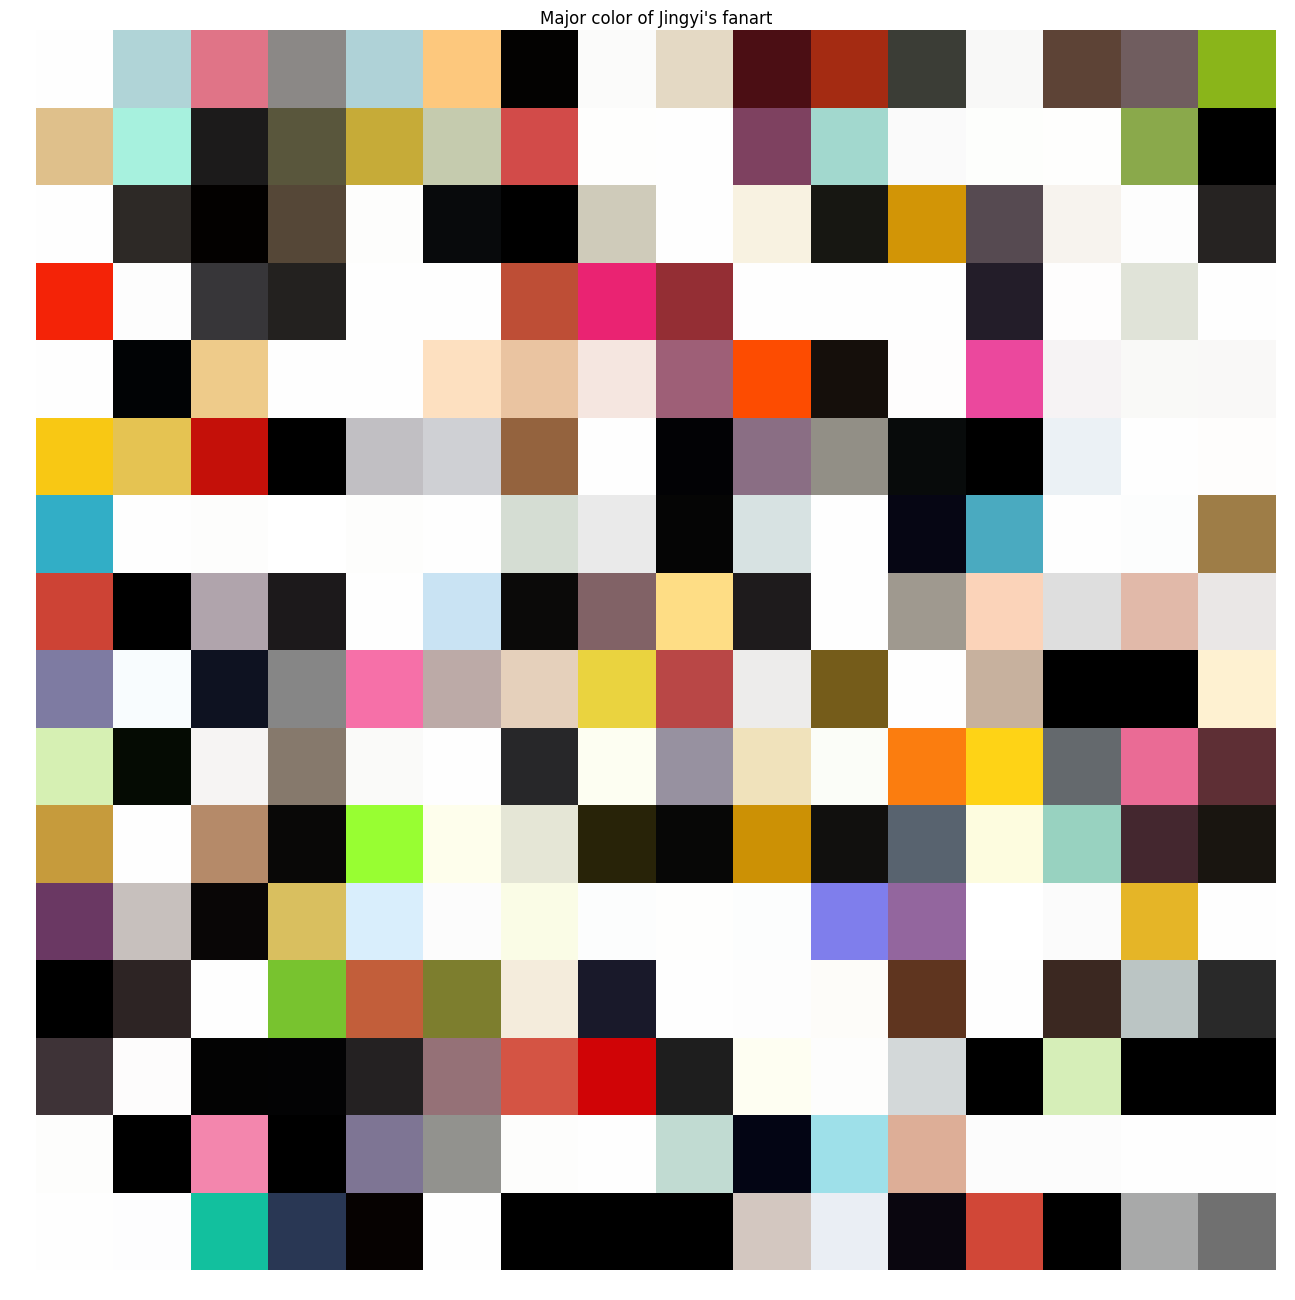

In [71]:
totalsquares = len(hexes)
side = int(np.ceil(np.sqrt(totalsquares)))

fig = plt.figure(figsize=(side,side))
ax1 = fig.add_subplot(111, aspect='equal')

i = 0
j = 0
patchlen = 1.0/side
for hexcolor in hexes:
    ax1.add_patch(
        patches.Rectangle(
            (i, j),     # (x,y)
            patchlen,          # width
            patchlen,          # height
            facecolor = '#'+str(hexcolor),
            edgecolor = "none"
        )
    )
    i += patchlen
    if i >= 1:
        i = 0
        j += patchlen

plt.title("Major color of Jingyi's fanart")
plt.axis('off')
plt.show()
    
#fixes to maybe make - white/black handling, get second color
#order by hue? 
# took about 15m for 256 images

In [69]:
print hexes

['fefefe', 'fdfdfe', '12c09e', '293754', '060201', 'fefefe', '000000', '000000', '000000', 'd3c7c0', 'eaeef4', '0a060f', 'd14737', '000000', 'a8a9a9', '707070', 'fdfdfc', '000000', 'f386ad', '000000', '7e7594', '92928e', 'fdfdfc', 'fefefe', 'c1dbd2', '030514', '9ee0e9', 'ddae97', 'fcfcfc', 'fcfcfc', 'fefefe', 'fefefe', '3e3337', 'fdfcfc', '030303', '030304', '242122', '957177', 'd45444', 'd00406', '1e1e1e', 'fefef2', 'fdfdfc', 'd3d8d9', '000000', 'd6eeb8', '000000', '000000', '000000', '2d2424', 'fefefe', '78c32f', 'c25e3a', '7d7e2e', 'f4ecdc', '19192a', 'fefefe', 'fdfdfd', 'fdfcf9', '5f351f', 'fefefe', '3b2821', 'bbc5c4', '292929', '6a3863', 'c7c0bd', '090606', 'd9bf5f', 'd9eefc', 'fcfcfc', 'fafce6', 'fcfdfd', 'fefefd', 'fcfdfd', '7f7eec', '93669e', 'ffffff', 'fbfbfb', 'e5b527', 'fefefe', 'c69b3c', 'fefefe', 'b58a69', '090807', '98fe32', 'fefeec', 'e5e6d6', '282308', '070706', 'cc9105', '11100e', '58636f', 'fdfcdf', '98d2c0', '44272f', '191510', 'd6f0b3', '050b03', 'f6f4f3', '86796c',

In [43]:
#getting avg color of image

NUM_CLUSTERS = 5
resize_w = 500

print 'reading image'
im = Image.open('runt in the sink.png')
w, h = im.size
ratio = w*1.0/500
new_w = int(round(w/ratio))
new_h = int(round(h/ratio))
print new_w, new_h
im = im.resize((new_w, new_h))     
ar = scipy.misc.fromimage(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype('float')
print 'finding clusters'
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print 'cluster centres:\n', codes

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
peak = peak.astype(int)
print 'peaks are ', peak

colour = ''.join(chr(c) for c in peak).encode('hex')[0:6]
print 'most frequent is %s (#%s)' % (peak, colour)

reading image
500 292
finding clusters
cluster centres:
[[ 253.30979221  224.40719174  192.66885654  255.        ]
 [ 221.44868841  109.40371322  128.0340748   255.        ]
 [ 123.12611687  152.65582559  158.5630361   255.        ]
 [ 215.46752242  178.64131612  182.19080575  255.        ]
 [ 254.42946941  242.0363439   228.59973142  255.        ]]
peaks are  [253 224 192 255]
most frequent is [253 224 192 255] (#fde0c0f)


In [12]:

def to_rgb3b(im):
    # as 3a, but we add an extra copy to contiguous 'C' order
    # data
    return np.dstack([im.astype(np.uint8)] * 3).copy(order='C')


In [14]:
#create a list of images
allfiles=os.listdir(im_dir)
imlist = []
for filename in allfiles:
    if filename[-4:] in [".png",".PNG"] or filename[-4:] in [".jpg",".JPG"] or filename[-5:] in [".jpeg",".JPEG"]:
        imlist.append(filename)
n = len(imlist)

#extract feature vector for each image
features = np.zeros((n,3))
for i in range(n):
    print 'working on ', imlist[i]
    im = np.array(Image.open(imlist[i]))
    if im.shape[-1] > 3:
        im = to_rgb3b(im)
    R = np.mean(im[:,:,0].flatten())
    G = np.mean(im[:,:,1].flatten())
    B = np.mean(im[:,:,2].flatten())
    features[i] = np.array([R,G,B])


working on  "ART".png
working on  17th century population growth.png
working on  ?_____?.png
working on  ab.jpg
working on  accidents.jpg
working on  ahappy 39th bird.png
working on  alex and his fucking guitar.png
working on  alicia and capy small.png
working on  alicia and capy.png
working on  alicia.png
working on  amazing.png
working on  amnesinoon.png
working on  ann eats poop.png
working on  ann falls.png
working on  ap art 5 2010-2011 019.png
working on  ap art 5 2010-2011 020.png
working on  apogee.png
working on  armchair.jpg
working on  art.png
working on  asd.png
working on  ashley.png
working on  Average.png
working on  baby bison.jpg
working on  bad.png
working on  ben.png
working on  bio.png
working on  birds.jpg
working on  blackseafoam.png
working on  bleh.png
working on  blurryyyyy.jpg
working on  brain.png
working on  break it yourself.png
working on  brutus.png
working on  burberry i.png
working on  byron ref.png
working on  card1.jpg
working on  card2.jpg
working on

NameError: name 'hcluster' is not defined

In [17]:
tree = hcluster(features)

In [37]:
drawdendrogram(tree,imlist,'output.png')

In [45]:
#create a list of images
new_im_dir = '/Users/noon/Pictures/Pictures by me/OLD, MOVE TO EXTERNAL HD/old things in general!'
os.chdir(new_im_dir)
allfiles=os.listdir(new_im_dir)
imlist = []
for filename in allfiles:
    if filename[-4:] in [".png",".PNG"] or filename[-4:] in [".jpg",".JPG"] or filename[-5:] in [".jpeg",".JPEG"]:
        imlist.append(filename)
n = len(imlist)

#extract feature vector for each image
features = np.zeros((n,3))
for i in range(n):
    print 'working on ', imlist[i]
    im = np.array(Image.open(imlist[i]))
    if im.shape[-1] > 3:
        im = to_rgb3b(im)
    R = np.mean(im[:,:,0].flatten())
    G = np.mean(im[:,:,1].flatten())
    B = np.mean(im[:,:,2].flatten())
    features[i] = np.array([R,G,B])

tree2 = hcluster(features)

working on  atonomy_thats_bad_dragon.png
working on  babykougra.jpg
working on  Bannet.png
working on  blaziken.png
working on  Bonsly.png
working on  bulbasaurimg.png
working on  CamoWocky.png
working on  caterpie.png
working on  chikku.png
working on  Collab_plusleboy.png
working on  CURSED SEAL jan 07.png
working on  cydaquial.png
working on  drewspoke.png
working on  eboneon.png
working on  ep1.png
working on  ep2.png
working on  ep3.png
working on  ep4.png
working on  evvevo.png
working on  faeriepoogle.png
working on  fakes.png
working on  feb 06.png
working on  first archive.png
working on  Flareon.png
working on  Flygon.png
working on  Flygon_plushie.png
working on  foxeh.jpg
working on  ftyu.PNG
working on  Garbirlen.png
working on  happybdayselena.png
working on  Huntail&Gorbysse.png
working on  jan 06 neo.png
working on  jan 06.png
working on  jan 22 06.png
working on  jan 8 06.png
working on  jiggley.png
working on  kimiko.png
working on  may 5, 2007.png
working on  me!!!!!

In [50]:
total_width = 0
max_height = 0
indices = get_cluster_elements(tree2)
for i in indices:
    nodeim = Image.open(imlist[i])
    ns = nodeim.size
    total_width += ns[0]
    if max_height < ns[1]:
        max_height = ns[1]


In [51]:
print total_width, max_height

24704 730


In [55]:
img=Image.new('RGB',(total_width,max_height),(255,255,255))
w_run = 0

for i in indices:
    print imlist[i]
    nodeim = Image.open(imlist[i])
    ns = nodeim.size
    img.paste(nodeim, (w_run, 0))
    w_run += ns[0]

img.save('montage.png', quality=100)
    

ftyu.PNG
kimiko.png
Request_pika.png
CURSED SEAL jan 07.png
pikastake.png
ep2.png
ep3.png
ep1.png
ep4.png
rayquaz.png
typloscale.png
teamTREON.png
mew.png
jan 8 06.png
chikku.png
happybdayselena.png
Snowkoocith.png
pika.png
Request_lati@s.png
faeriepoogle.png
Huntail&Gorbysse.png
jiggley.png
Garbirlen.png
jan 06.png
Rayquaza.png
fakes.png
me!!!!!!!!!!!!.png
Request_gar.png
babykougra.jpg
foxeh.jpg
may 5, 2007.png
mudikptorchic.png
sinsi.png
Ugly.png
feb 06.png
Request_nine.png
Bannet.png
nov 05.png
Mutant_Niptor.png
Yoshi1.png
cydaquial.png
Bonsly.png
Flareon.png
torchic.png
jan 06 neo.png
pianta.png
shadow lugi.png
jan 22 06.png
first archive.png
shuppet.png
ugly9.png
plusleimage.png
ugly4.png
Yoshi2.png
eboneon.png
Mightyena.png
bulbasaurimg.png
mimumimage.png
drewspoke.png
Tropious.png
Request_snoball.png
royalflost.png
shepelo.png
caterpie.png
Collab_plusleboy.png
evvevo.png
Flygon_plushie.png
CamoWocky.png
skar.png
Flygon.png
blaziken.png
sepgoosezangvioer.png
